# Analysis Code for 4-Point Correlator

## General parameters and functions


In [1]:
%pip install numpy scipy iminuit matplotlib scienceplots

Note: you may need to restart the kernel to use updated packages.


In [55]:
import os
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from matplotlib import ticker
import scienceplots

### Lattice setup

- PACS-CS Lattice QCD gauge ensemble:  
  [RC32x64_B1900Kud01378100Ks01364000C1715](https://www.jldg.org/ildg-data/PACSCSconfig.html#ENSEMBLE) _(all 5 series in the #6 ensemble)_  
  _Ref: [Aoki_PhysRevD.79.034503](/ccbar/pdf/Aoki_PhysRevD.79.034503.pdf)_

- Gauge configurations
  - $2 + 1$ flavor dynamical LQCD configurations on $32^3\times64$ lattice
    - RG improved Iwasaki gauge action ($\beta = 1.90$)
    - O(a)-improved Wilson quark action ($\kappa_{ud}=0.1378100$, $C_{\rm SW}=1.715$)
  - Pion Mass: $155.7\ \text{MeV}$ _(Almost the physical pion mass)_
  - Spatial size: $L = 2.902 42\ \text{fm}$ ($a = 0.0907(13)\ \text{fm}$)
  - Lattice cutoff: $a^{-1} ∼ 2.1753\ \text{GeV}$

- Charm quark is introduced by the quenched approximation by using the relativistic heavy quark action  
  _Ref: [Namekawa_PhysRevD.84.074505](/ccbar/pdf/Namekawa_PhysRevD.84.074505.pdf)_

- **Coulomb** and **Landau** gauge fixing

- **Wall source** and **point sink** for quark propagators

- Number of source points: **64**


In [56]:
xyz_size = 32
t_size = 64
a = 0.090713
a_invrs = 2.1753

t_half = int(t_size / 2)
xyz_cube = int(xyz_size**3)

### Paths, file names and more


In [57]:
droot = "/Volumes/X6/data/ccbar"

gfix = ["gfix_C", "gfix_L"]
gauge = ["Coulomb", "Landau"]
chan = ["ps", "v"]
binID = ["BIN" + f"{i:02}" for i in range(1, 19)]

### Customed functions

In [58]:
# cart2sphr (python version)
def cart2sphr_py(data):
    reshdata = data.reshape(-1, 2)
    datatmp = []
    for x in range(int(xyz_size / 2 + 1)):
        for y in range(x, int(xyz_size / 2 + 1)):
            for z in range(y, int(xyz_size / 2 + 1)):
                distance = (x**2 + y**2 + z**2) ** 0.5
                dxyz = reshdata[x + xyz_size * (y + xyz_size * z)]
                datatmp.append(np.array([distance, dxyz[0], dxyz[1]]))

    sphrdata = np.array(datatmp)
    sorted_indices = np.argsort(sphrdata[:, 0])
    sphrsorted = sphrdata[sorted_indices]
    return np.array(sphrsorted)


# 4ptcorr plot
def corrPlot4pt(data):
    fig, ax = plt.subplots()

    ax.scatter(
        data[:, 0] * a,
        data[:, 1] / data[0, 1],
        label=r"$t/a=29$",
        marker=".",
    )

    ax.legend()
    ax.set_xlabel(r"$r\ [{\rm fm}]$")
    ax.set_xlim(0, 1.4)
    ax.set_ylabel(r"$\tilde{C}(\mathbf{r},t)=C(\mathbf{r},t)/C(0,t)$")
    ax.set_ylim(-0.05, 1)

    plt.plot()
    plt.show()
    plt.close()

## Preparation

### Time reversal

Calculate $C_{\text{ave}}(n_t) = [C(n_t) + C(N_t - n_t)]/2$


In [ ]:
for ig in range(2):
    ofpath = f"{droot}/{gfix[ig]}/4pt/trev"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for ich in range(2):
        for it in range(t_half):
            t1 = f"{it:+03}"
            t2 = f"{(t_size - it)%t_size:+03}"
            for ibin in range(18):
                ifname_t1 = f"{droot}/{gfix[ig]}/4pt/binned/4pt.{chan[ich]}.{t1}.{gfix[ig]}.{binID[ibin]}"
                ifname_t2 = f"{droot}/{gfix[ig]}/4pt/binned/4pt.{chan[ich]}.{t2}.{gfix[ig]}.{binID[ibin]}"
                ofname = f"{droot}/{gfix[ig]}/4pt/trev/{chan[ich]}.{t1}.{gfix[ig]}.{binID[ibin]}"
                assert os.path.exists(ifname_t1)
                assert os.path.exists(ifname_t2)

                os.system(f"bin/mean -l {xyz_cube} -o {ofname} {ifname_t1} {ifname_t2}")

            print(f"got [C({t1}) + C({t2})]/2 ({gauge[ig]}, {chan[ich]})")

In [ ]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/trev/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

We simply denote $C_{\text{ave}}(n_t)$ as $C(n_t)$ from below


### $A_1^+$ projection

$$
\phi(r)=\frac{1}{48}\sum_{g\in O_h}\phi(g^{-1}(\mathbf{x}-\mathbf{y}))
$$

In [8]:
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/trev"
    ofpath = f"{droot}/{gfix[ig]}/4pt/a1plus"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files

    os.system(f"bin/a1plus -n {xyz_size} -d {ofpath} {ifpath}/*")

In [ ]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/a1plus/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

### Jackknife resampling

In [10]:
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/a1plus"
    ofpath = f"{droot}/{gfix[ig]}/4pt/jksamp"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for ich in range(2):
        for it in range(t_half):
            t=f"{it:+03}"
            os.system(f"bin/jre -l {xyz_cube} -d {ofpath} {ifpath}/{chan[ich]}.{t}.*")

In [ ]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/jksamp/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

## Correlator


In [14]:
# jackknife average
for ig in range(2):
    corr_result_path = f"result/{gauge[ig]}/correlator"
    os.system(f"rm -rf {corr_result_path}")  # clear data
    os.makedirs(corr_result_path, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ich in range(2):
            iflist = f"{droot}/{gfix[ig]}/4pt/jksamp/{chan[ich]}.{t}.{gfix[ig]}.*"
            ofname = f"{corr_result_path}/{chan[ich]}.{t}"

            iftest = iflist[:-1] + binID[0]
            assert os.path.exists(iftest)

            os.system(f"bin/mean -l {xyz_cube} -o {ofname} -jc {iflist}")

    # Convert all data to spherical coordinate
    os.system(
        f"bin/cart2sphr -n {xyz_size} -d {corr_result_path} -p sphr -s txt {corr_result_path}/*"
    )

### Figure

In [59]:
corrfig_root = "fig/corr"
for ig in range(2):
    if not os.path.exists(f"{corrfig_root}/{gauge[ig]}"):
        os.makedirs(f"{corrfig_root}/{gauge[ig]}")

#### Read data

In [60]:
ps_c, v_c, ps_l, v_l = [[] for _ in range(4)]
for it in range(32):
    t = f"{it:+03}"
    ps_c.append(np.loadtxt(f"result/Coulomb/correlator/sphr.ps.{t}.txt"))
    v_c.append(np.loadtxt(f"result/Coulomb/correlator/sphr.v.{t}.txt"))
    ps_l.append(np.loadtxt(f"result/Landau/correlator/sphr.ps.{t}.txt"))
    v_l.append(np.loadtxt(f"result/Landau/correlator/sphr.v.{t}.txt"))

#### Overall

set style

In [61]:
plt.style.use(["science", "nature"])
# plt.style.use("default")

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 3,
    "bbox_to_anchor": (-0.08, -0.05),
    "handletextpad": 0,
    "labelspacing": 0.1,
    "fontsize": 12,
}

##### PS - Coulomb

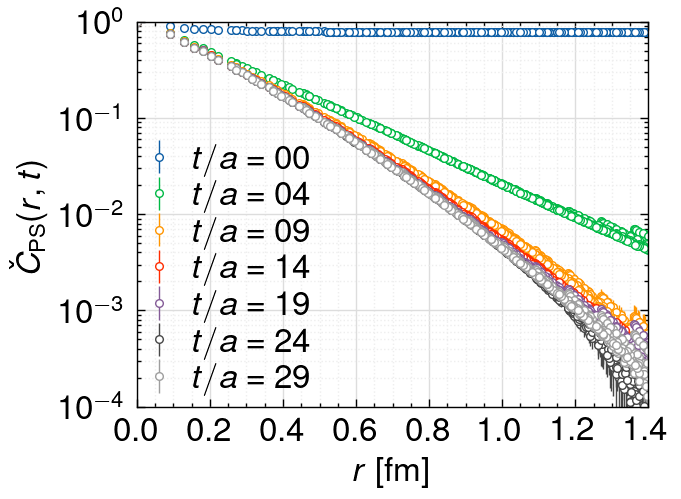

In [62]:
fig, ax = plt.subplots()

trange = np.append(np.array([0]), np.arange(4, 30, 5))

for i in trange:
    ax.errorbar(
        ps_c[i][:, 0] * a,
        ps_c[i][:, 1] / ps_c[i][0][1],
        ps_c[i][:, 2] / ps_c[i][0][1],
        label=r"$t/a=\ $" + str(i).rjust(2, "0"),
        **errbar_plot_style
    )

ax.legend(**legend_style)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_xlim(0, 1.4)

ax.set_ylabel(r"$\check{C}_{\rm PS}(r,t)$", fontsize=12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
# ax.set_ylim(-0.05, 1)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)

ax.tick_params(labelsize=12)

fig.savefig(f"{corrfig_root}/Coulomb/4ptcorr-overview(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

##### PS - Landau

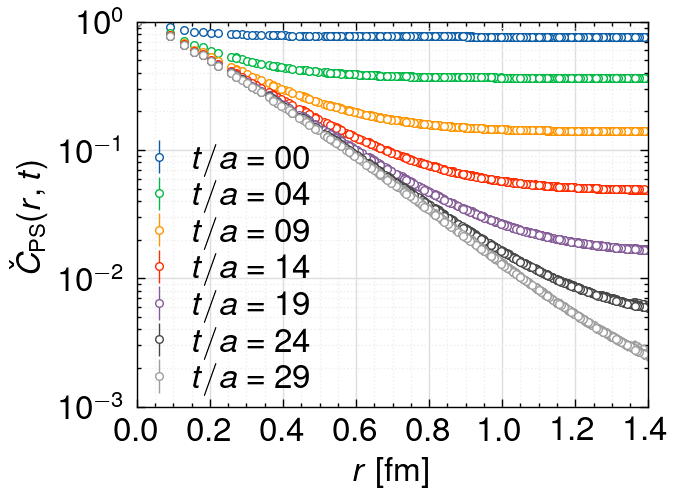

In [63]:
fig, ax = plt.subplots()

trange = np.append(np.array([0]), np.arange(4, 30, 5))

for i in trange:
    ax.errorbar(
        ps_l[i][:, 0] * a,
        ps_l[i][:, 1] / ps_l[i][0, 1],
        ps_l[i][:, 2] / ps_l[i][0, 1],
        label=r"$t/a=\ $" + str(i).rjust(2, "0"),
        **errbar_plot_style
    )

ax.legend(**legend_style)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_xlim(0, 1.4)

ax.set_ylabel(r"$\check{C}_{\rm PS}(r,t)$", fontsize=12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
# ax.set_ylim(-0.05, 1)
ax.set_yscale("log")
ax.set_ylim(1e-3, 1)

ax.tick_params(labelsize=12)

fig.savefig(f"{corrfig_root}/Landau/4ptcorr-overview(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

#### Close look

set style

In [51]:
plt.style.use(["science", "nature"])
# plt.style.use("default")

errbar_plot_style = {
    "fmt": ".",
    "markersize": 7,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 2,
    "bbox_to_anchor": (0.92, 1.07),
    "handletextpad": 0,
    "labelspacing": 0.1,
    "fontsize": 12,
}

##### PS - Coulomb

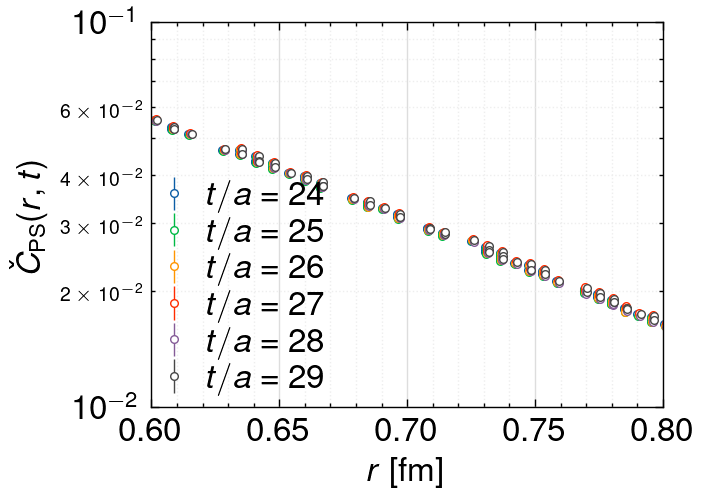

In [64]:
fig, ax = plt.subplots()

trange = np.arange(24, 30, 1)

for i in trange:
    re_i = i - trange[0]
    t_all = trange[-1] - trange[0]
    ax.errorbar(
        ps_c[i][:, 0] * a + 0.00025 * (re_i - np.ceil(t_all / 2)),
        ps_c[i][:, 1] / np.float64(ps_c[i][0][1]),
        ps_c[i][:, 2] / np.float64(ps_c[i][0][1]),
        label=r"$t/a=\ $" + str(i).rjust(2, "0"),
        **errbar_plot_style
    )

ax.legend(**legend_style)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.set_xlim(0.6, 0.8)

ax.set_ylabel(r"$\check{C}_{\rm PS}(r,t)$", fontsize=12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
# ax.set_ylim(0.0025, 0.0045)
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e-1)

ax.tick_params(labelsize=12)

# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)  # 启用科学计数法
# formatter.set_powerlimits((-1, 1))  # 强制使用科学计数法的范围

# ax.yaxis.set_major_formatter(formatter)

fig.savefig(f"{corrfig_root}/Coulomb/4ptcorr-closeview(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

##### PS - Landau

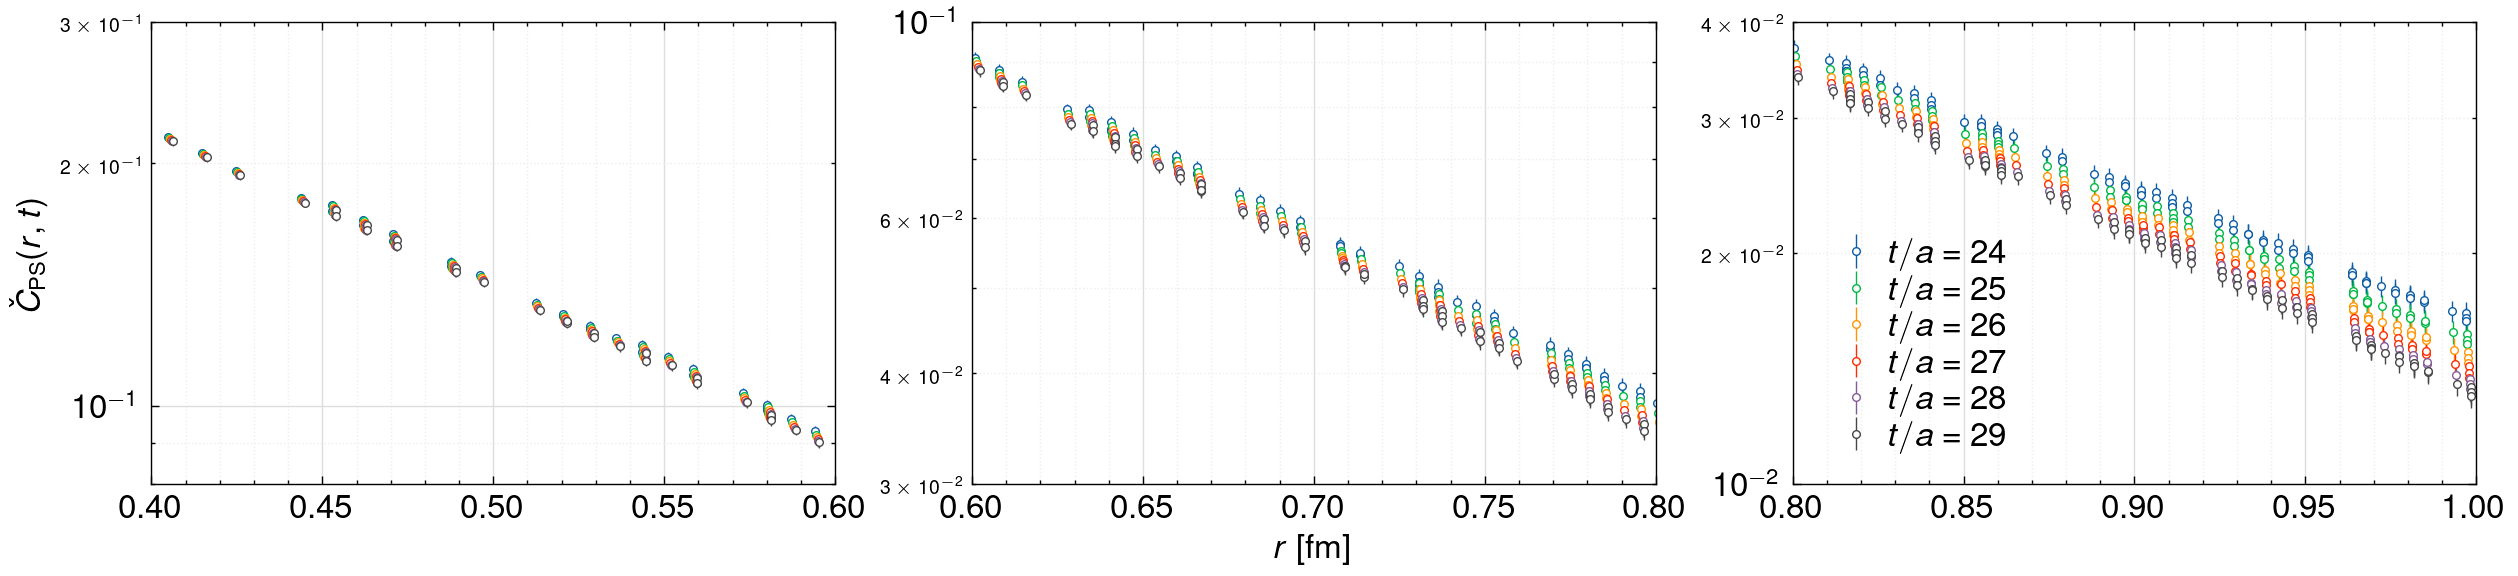

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

trange = np.arange(24, 30, 1)


def close_plot(xmin, xmax, ymin, ymax, ax):
    for i in trange:
        re_i = i - trange[0]
        t_all = trange[-1] - trange[0]
        ax.errorbar(
            ps_l[i][:, 0] * a + 0.00025 * (re_i - np.ceil(t_all / 2)),
            ps_l[i][:, 1] / np.float64(ps_l[i][0][1]),
            ps_l[i][:, 2] / np.float64(ps_l[i][0][1]),
            label=r"$t/a=\ $" + str(i).rjust(2, "0"),
            **errbar_plot_style
        )

    # Set grid (reserved)
    ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    ax.set_xlim(xmin, xmax)
    ax.set_yscale("log")
    ax.set_ylim(ymin, ymax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.tick_params(labelsize=12)


close_plot(0.4, 0.6, 8e-2, 3e-1, axs[0])
axs[0].set_ylabel(r"$\check{C}_{\rm PS}(r,t)$", fontsize=12)

close_plot(0.6, 0.8, 3e-2, 1e-1, axs[1])
axs[1].set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)

close_plot(0.8, 1.0, 1e-2, 4e-2, axs[2])
legend_style = {
    "loc": 3,
    # "bbox_to_anchor": (0.92, 1.07),
    "handletextpad": 0,
    "labelspacing": 0.1,
    "fontsize": 12,
}
axs[2].legend(**legend_style)
fig.savefig(f"{corrfig_root}/Landau/4ptcorr-closeview(article).eps", format="eps", dpi=600)
fig.savefig(f"{corrfig_root}/Landau/4ptcorr-closeview(article).png", dpi=600)
plt.show()
plt.close()


#### NBS wave function (Coulomb vs Landau)

set style

In [69]:
plt.style.use(["science", "nature"])

errbar_plot_style1 = {
    "fmt": "D",
    "markersize": 3.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "color": "xkcd:primary blue",
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

errbar_plot_style2 = {
    "fmt": "s",
    "markersize": 3.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "color": "xkcd:bright red",
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    # "loc": 10,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

t_compare = 29

##### PS

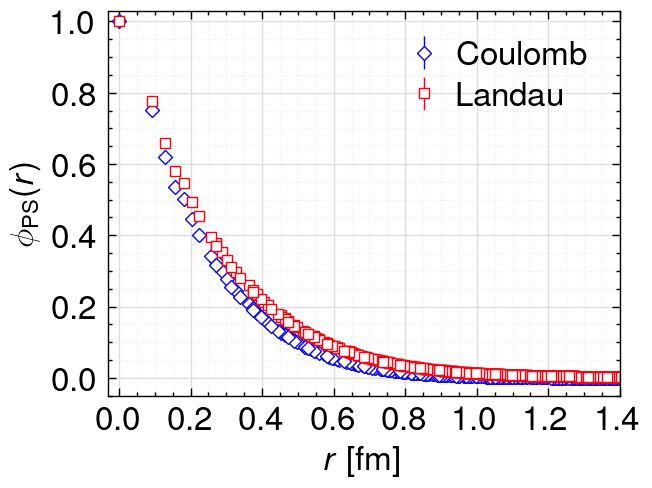

In [73]:
fig, ax = plt.subplots()

ax.errorbar(
    ps_c[t_compare][:, 0] * a,
    ps_c[t_compare][:, 1] / ps_c[t_compare][0][1],
    ps_c[t_compare][:, 2] / ps_c[t_compare][0][1],
    label="Coulomb",
    **errbar_plot_style1,
)

ax.errorbar(
    ps_l[t_compare][:, 0] * a,
    ps_l[t_compare][:, 1] / ps_l[t_compare][0][1],
    ps_l[t_compare][:, 2] / ps_l[t_compare][0][1],
    label="Landau",
    **errbar_plot_style2,
)

ax.legend(**legend_style)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_xlim(-0.03, 1.4)

ax.set_ylabel(r"$\phi_{\rm PS}(r)$", fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylim(-0.05, 1.03)

ax.tick_params(labelsize=12)

fig.savefig(f"{corrfig_root}/NBS-Gcompare-PS(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

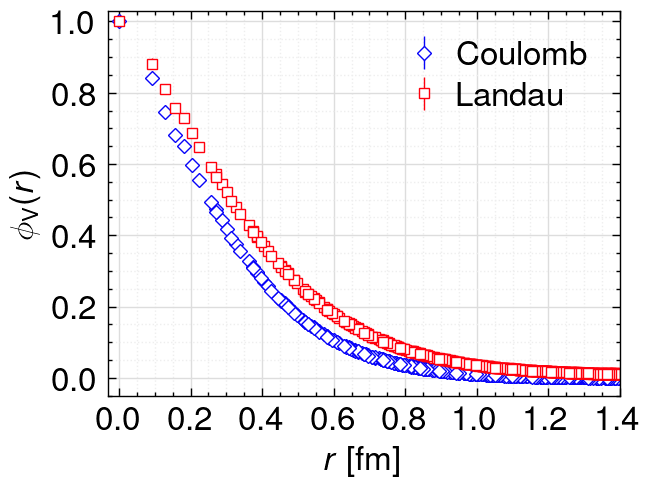

In [74]:
fig, ax = plt.subplots()

ax.errorbar(
    v_c[t_compare][:, 0] * a,
    v_c[t_compare][:, 1] / v_c[t_compare][0][1],
    v_c[t_compare][:, 2] / v_c[t_compare][0][1],
    label="Coulomb",
    **errbar_plot_style1,
)

ax.errorbar(
    v_l[t_compare][:, 0] * a,
    v_l[t_compare][:, 1] / v_l[t_compare][0][1],
    v_l[t_compare][:, 2] / v_l[t_compare][0][1],
    label="Landau",
    **errbar_plot_style2,
)

ax.legend(**legend_style)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_xlim(-0.03, 1.4)

ax.set_ylabel(r"$\phi_{\rm V}(r)$", fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylim(-0.05, 1.03)

ax.tick_params(labelsize=12)

fig.savefig(f"{corrfig_root}/NBS-Gcompare-V(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

## Pre-potential


In [15]:
# main part
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/jksamp"
    ofpath = f"{droot}/{gfix[ig]}/4pt/prev"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files

    os.system(f"bin/prev -n {xyz_size} -d {ofpath} {ifpath}/*")

In [16]:
# jackknife average
for ig in range(2):
    result_path = f"result/{gauge[ig]}/prev"
    os.system(f"rm -rf {result_path}")  # clear data
    os.makedirs(result_path, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ich in range(2):
            iflist = f"{droot}/{gfix[ig]}/4pt/prev/{chan[ich]}.{t}.{gfix[ig]}.*"
            ofname = f"{result_path}/{chan[ich]}.{t}"

            iftest = iflist[:-1] + binID[0]
            assert os.path.exists(iftest)

            os.system(f"bin/mean -l {xyz_cube} -o {ofname} -jc {iflist}")

    # Convert all data to spherical coordinate
    os.system(
        f"bin/cart2sphr -n {xyz_size} -d {result_path} -p sphr -s txt {result_path}/*"
    )

### Figure

#### Read data

In [29]:
ps_c, v_c, ps_l, v_l = [[] for _ in range(4)]
for it in range(32):
    t = f"{it:+03}"
    ps_c.append(np.loadtxt(f"result/Coulomb/prev/sphr.ps.{t}.txt"))
    v_c.append(np.loadtxt(f"result/Coulomb/prev/sphr.v.{t}.txt"))
    ps_l.append(np.loadtxt(f"result/Landau/prev/sphr.ps.{t}.txt"))
    v_l.append(np.loadtxt(f"result/Landau/prev/sphr.v.{t}.txt"))

set style

In [30]:
plt.style.use(["science", "nature"])
# plt.style.use("default")

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 2,
    "bbox_to_anchor": (0.95, 1.02),
    "handletextpad": 0,
    "labelspacing": 0.3,
}

#### All time slices in one fig

##### PS - Coulomb

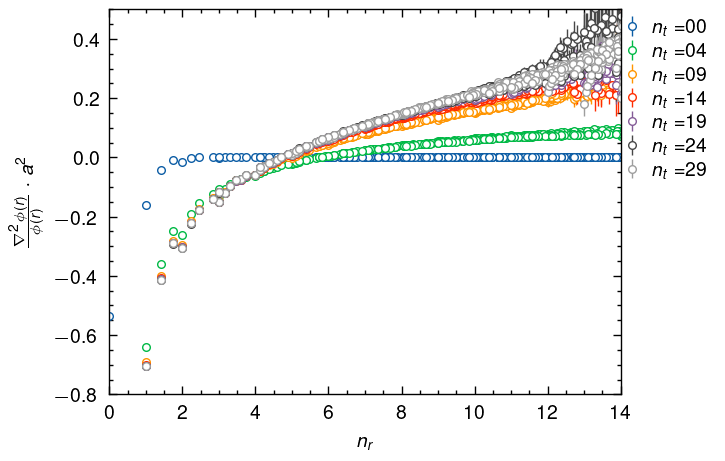

In [31]:
fig, ax = plt.subplots()

trange = np.append(np.array([0]), np.arange(4, 30, 5))

for i in trange:
    ax.errorbar(
        ps_c[i][:, 0],
        ps_c[i][:, 1],
        ps_c[i][:, 2],
        label=r"$n_t=$" + str(i).rjust(2, "0"),
        **errbar_plot_style
    )

ax.legend(**legend_style)

ax.set_xlabel(r"$n_r$")
ax.set_xlim(0, 14)

ax.set_ylabel(r"$\frac{\nabla^2\phi(r)}{\phi(r)}\cdot a^2$")
ax.set_ylim(-0.8, 0.5)

plt.plot()
plt.show()

# fig.savefig("{}.png".format(filename), dpi=600)
plt.close()

## Kawanai-Sasaki function

### Figure

set style and set path

In [6]:
plt.style.use(["science", "nature"])

homePath = os.getenv("HOME")
codeRoot = f"{homePath}/ccbar"

fksfig_root = "fig/fks"
for ig in range(2):
    if not os.path.exists(f"{fksfig_root}/{gauge[ig]}"):
        os.makedirs(f"{fksfig_root}/{gauge[ig]}")
        
errbar_plot_style = {
        "fmt": ".",
        "markersize": 6,
        "markeredgewidth": 0.5,
        "linewidth": 0.5,
        "markerfacecolor": "white",
        # "fillstyle": "none",
    }

legend_style = {
    "loc": 1,
    # "bbox_to_anchor": (0.95, 1.02),
    "handletextpad": 0.3,
    "labelspacing": 0.3,
    "fontsize": 12,
}

#### Coulomb

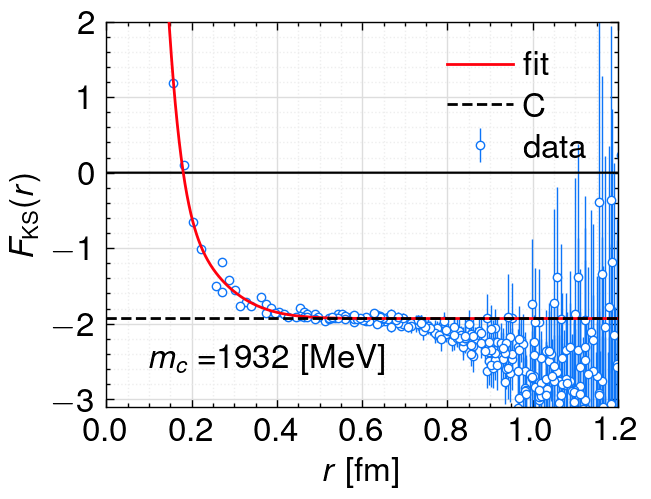

In [20]:
t = 29
ttext = str(t).rjust(2, "0")

igauge = 0

rmin = 0.01
rmax = [0.82, 0.82]

datapath = [
    f"{codeRoot}/result/c4pt/FKS-TI",
    f"{codeRoot}/result/l4pt/FKS-TI",
]


def gaussian(x, A, B, C):
    return A * np.exp(-(x**2) / B) + C


def gaussian2(x, A1, B1, A2, B2, C):
    return gaussian(x, A1, B1, 0) + gaussian(x, A2, B2, 0) + C


para = {
    "A1": -1,
    "B1": 10,
    "A2": -10,
    "B2": 1,
    "C": 1,
}

yrange = [[1.5, 2.5], [1.1, 2.1]]
# yrange = [[-2, 3], [-2, 3]]
# text_ysite = [2.43, 2.03]

# Fit
rawdata = np.loadtxt(f"{datapath[igauge]}/txt.{ttext}", dtype=np.float64)

mask = (rawdata[:, 0] > rmin / a) & (rawdata[:, 0] < rmax[igauge] / a)
subdata = rawdata[mask]
sorted_indices = np.argsort(subdata[:, 0])

fitdata = subdata[sorted_indices]

fitsites = fitdata[:, 0]
fitfks = fitdata[:, 1]
fiterr = fitdata[:, 2]

# Fit
least_squares = LeastSquares(fitsites, fitfks, fiterr, gaussian2)  # type: ignore
m = Minuit(least_squares, **para)  # type: ignore
m.migrad()

# Draw
fig, ax = plt.subplots()

ax.errorbar(
    rawdata[:, 0] * a,
    -rawdata[:, 1] * a_invrs,
    rawdata[:, 2] * a_invrs,
    label="data",
    # color="xkcd:primary blue",
    color="xkcd:deep sky blue",
    zorder=2,
    **errbar_plot_style,
)
x_fit = np.arange(0, 28, 0.01)
ax.plot(
    x_fit * a,
    -gaussian2(x_fit, *m.values) * a_invrs,
    linewidth=1,
    color="xkcd:bright red",
    zorder=3,
    label="fit",
)
ax.plot(
    x_fit * a,
    np.full(x_fit.shape, -m.values["C"]) * a_invrs,
    linestyle="dashed",
    linewidth=1,
    label="C",
    zorder=4,
    color="black",
)
ax.plot(
    x_fit * a,
    np.full(x_fit.shape, 0),
    linewidth=0.8,
    color="black",
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

# ax.minorticks_on()
ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(0, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$F_{\rm KS}(r)$", fontsize=12)
ax.set_ylim(-3.1, 2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.text(
    0.1,
    -2.6,
    r"$m_c =$"
    + r"${}$".format(round(m.values["C"] * a_invrs * 1000))
    + r"$\ [{\rm MeV}]$",
    fontsize=12,
)

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{fksfig_root}/{gauge[igauge]}/fks_t{ttext}(ti).eps", dpi=600)
plt.close()

#### Landau

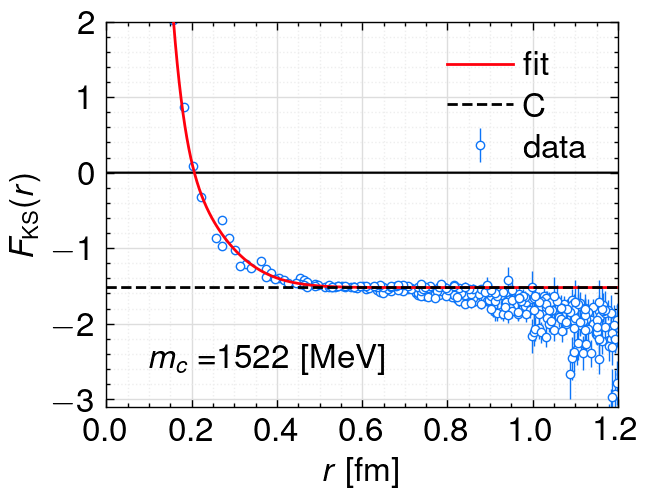

In [21]:
t = 29
ttext = str(t).rjust(2, "0")

igauge = 1

rmin = 0.01
rmax = [0.82, 0.82]

datapath = [
    f"{codeRoot}/result/c4pt/FKS-TI",
    f"{codeRoot}/result/l4pt/FKS-TI",
]


def gaussian(x, A, B, C):
    return A * np.exp(-(x**2) / B) + C


def gaussian2(x, A1, B1, A2, B2, C):
    return gaussian(x, A1, B1, 0) + gaussian(x, A2, B2, 0) + C


para = {
    "A1": -1,
    "B1": 10,
    "A2": -10,
    "B2": 1,
    "C": 1,
}

yrange = [[1.5, 2.5], [1.1, 2.1]]
# yrange = [[-2, 3], [-2, 3]]
# text_ysite = [2.43, 2.03]

# Fit
rawdata = np.loadtxt(f"{datapath[igauge]}/txt.{ttext}", dtype=np.float64)

mask = (rawdata[:, 0] > rmin / a) & (rawdata[:, 0] < rmax[igauge] / a)
subdata = rawdata[mask]
sorted_indices = np.argsort(subdata[:, 0])

fitdata = subdata[sorted_indices]

fitsites = fitdata[:, 0]
fitfks = fitdata[:, 1]
fiterr = fitdata[:, 2]

# Fit
least_squares = LeastSquares(fitsites, fitfks, fiterr, gaussian2)  # type: ignore
m = Minuit(least_squares, **para)  # type: ignore
m.migrad()

# Draw
fig, ax = plt.subplots()

ax.errorbar(
    rawdata[:, 0] * a,
    -rawdata[:, 1] * a_invrs,
    rawdata[:, 2] * a_invrs,
    label="data",
    color="xkcd:deep sky blue",
    zorder=2,
    **errbar_plot_style,
)
x_fit = np.arange(0, 28, 0.01)
ax.plot(
    x_fit * a,
    -gaussian2(x_fit, *m.values) * a_invrs,
    linewidth=1,
    color="xkcd:bright red",
    zorder=3,
    label="fit",
)
ax.plot(
    x_fit * a,
    np.full(x_fit.shape, -m.values["C"]) * a_invrs,
    linestyle="dashed",
    linewidth=1,
    label="C",
    zorder=4,
    color="black",
)
ax.plot(
    x_fit * a,
    np.full(x_fit.shape, 0),
    linewidth=0.8,
    color="black",
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

# ax.minorticks_on()
ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(0, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$F_{\rm KS}(r)$", fontsize=12)
ax.set_ylim(-3.1, 2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.text(
    0.1,
    -2.6,
    r"$m_c =$"
    + r"${}$".format(round(m.values["C"] * a_invrs * 1000))
    + r"$\ [{\rm MeV}]$",
    fontsize=12,
)

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{fksfig_root}/{gauge[igauge]}/fks_t{ttext}(ti).eps", dpi=600)
plt.close()

## Central potential

- Spin-independent potential

$$
V_0(r)=\frac{1}{4m_c}\Bigl[3\frac{\nabla^2 \phi_V(r)}{\phi_V(r)}+\frac{\nabla^2 \phi_{PS}(r)}{\phi_{PS}(r)}\Bigr]+\frac{1}{4}(3M_V+M_{PS})-2m_c
$$

- Spin-dependent potential

$$
V_s(r)=\frac{1}{m_c}\Bigl[\frac{\nabla^2 \phi_V(r)}{\phi_V(r)}- \frac{\nabla^2 \phi_{PS}(r)}{\phi_{PS}(r)}\Bigr]+(M_V-M_{PS})
$$

In [ ]:
# main part
mc = [0.88817, 0.69968]
for ig in range(2):
    ofpath = f"{droot}/{gfix[ig]}/4pt/potential"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ibin in range(18):
            prev_PS = f"{droot}/{gfix[ig]}/4pt/prev/ps.{t}.{gfix[ig]}.{binID[ibin]}"
            prev_V = f"{droot}/{gfix[ig]}/4pt/prev/v.{t}.{gfix[ig]}.{binID[ibin]}"
            of_v0 = f"{droot}/{gfix[ig]}/4pt/potential/v0.{t}.{gfix[ig]}.{binID[ibin]}"
            of_vs = f"{droot}/{gfix[ig]}/4pt/potential/vs.{t}.{gfix[ig]}.{binID[ibin]}"
            assert os.path.exists(prev_PS)
            assert os.path.exists(prev_V)

            os.system(
                f"bin/v-ti -n {xyz_size} -mps 1.3665 -mv 1.4148 -mc {mc[ig]}  -ov0 {of_v0} -ovs {of_vs} {prev_V} {prev_PS}"
            )

In [ ]:
# jackknife average and convert to spherical coordinate
cpot = ["v0", "vs"]
for ig in range(2):
    result_path = f"result/{gauge[ig]}/potential"
    os.system(f"rm -rf {result_path}")  # clear data
    os.makedirs(result_path, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ipot in range(2):
            iflist = f"{droot}/{gfix[ig]}/4pt/potential/{cpot[ipot]}.{t}.{gfix[ig]}.*"
            ofname = f"{result_path}/{cpot[ipot]}.{t}"

            iftest = iflist[:-1] + binID[0]
            assert os.path.exists(iftest)

            os.system(f"bin/mean -l {xyz_cube} -o {ofname} -jc {iflist}")
    
    os.system(f"bin/cart2sphr -n {xyz_size} -d {result_path} -p sphr -s txt {result_path}/*")
    

### String tension

In [ ]:
# Initialize
ifname = f"result/{gauge[0]}/potential/sphr.v0.+29.txt"

rfit_min = 0.01
rfit_max = 12


# Define Cornell potential
def cornell(r, A, sigma, V0):
    return -A / r + sigma * r + V0


# Make data
rawdata = np.loadtxt(ifname, dtype=np.float64)[0:xyz_cube]

mask = (rawdata[:, 0] > rfit_min) & (rawdata[:, 0] < rfit_max)
subdata = rawdata[mask]
sorted_indices = np.argsort(subdata[:, 0])

fitdata = subdata[sorted_indices]

fitsites = fitdata[:, 0]
fitprev = fitdata[:, 1]
fiterr = fitdata[:, 2]

# Fit
para = {
    "A": 1,
    "sigma": 0.1,
    "V0": 0.01,
}
least_squares = LeastSquares(fitsites, fitprev, fiterr, cornell)
m = Minuit(least_squares, **para)
m.migrad()

# Print result
# df = np.shape(fitdata)[0] - 3 - 1
# chi = m.fval
# print(f"χ^2/df = {chi / df}")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "color": "tab:blue",
    # "markerfacecolor": "white",
    "fillstyle": "none",
}

plot_style = {
    "linewidth": 3,
    "color": "red",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
}

ax.errorbar(
    rawdata[:, 0], rawdata[:, 1], rawdata[:, 2], label="data", **errbar_plot_style
)
x_fit = np.arange(0.01, 28, 0.01)
ax.plot(x_fit, cornell(x_fit, *m.values), label="fit", **plot_style)

ax.legend(**legend_style)

ax.set_xlabel(r"$n_r$")
ax.set_xlim(0, 15)

ax.set_ylabel(r"$\frac{\nabla^2\phi(r)}{\phi(r)}\cdot a^2$")
ax.set_ylim(-1.7, 0.3)

plt.plot()
plt.show()
plt.close()

print(f"V0(r) = -{m.values["A"]}/r + {m.values["sigma"]}r + {m.values["V0"]}")
print(f"sigma: {m.values["sigma"]}")
print(f"sqrt sigma: {m.values["sigma"] ** 0.5 * a_invrs}")
print(f"String tension: {m.values["sigma"] * a_invrs / a * 1000} [MeV/fm]")

### Figure

In [67]:
potfig_root = "fig/pot"
for ig in range(2):
    if not os.path.exists(f"{potfig_root}/{gauge[ig]}"):
        os.makedirs(f"{potfig_root}/{gauge[ig]}")

#### Read data

In [68]:
v0_c, vs_c, v0_l, vs_l = [[] for _ in range(4)]
for it in range(32):
    t = f"{it:+03}"
    v0_c.append(np.loadtxt(f"result/Coulomb/potential/sphr.v0.{t}.txt"))
    vs_c.append(np.loadtxt(f"result/Coulomb/potential/sphr.vs.{t}.txt"))
    v0_l.append(np.loadtxt(f"result/Landau/potential/sphr.v0.{t}.txt"))
    vs_l.append(np.loadtxt(f"result/Landau/potential/sphr.vs.{t}.txt"))

#### Seperate figures for each gauge

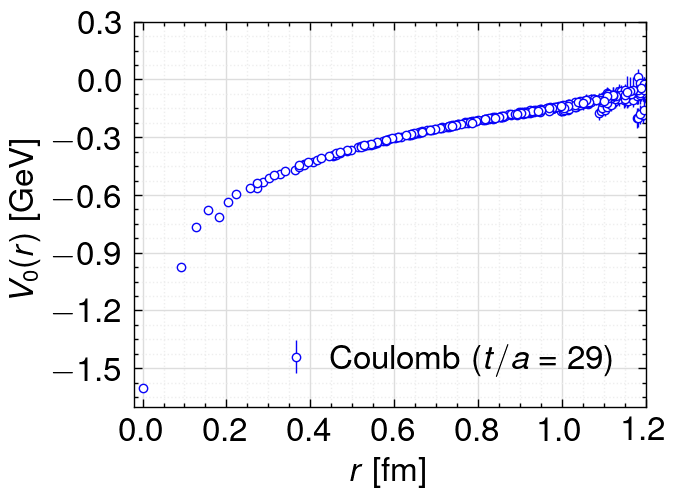

In [69]:
ct = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "color": "xkcd:primary blue",
    "markersize": 6,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    **errbar_plot_style,
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(-0.02, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$V_0(r)$ [GeV]", fontsize=12)
ax.set_ylim(-1.7, 0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/{gauge[0]}/v0.+29.eps", format="eps", dpi=600)
plt.close()

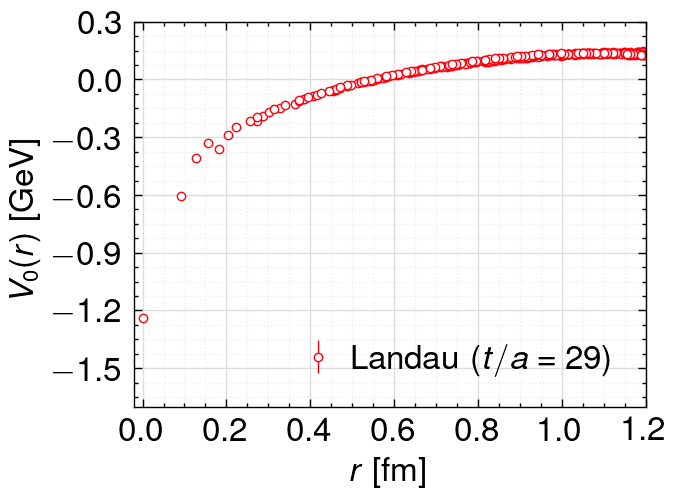

In [70]:
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "color": "xkcd:bright red",
    "markersize": 6,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1],
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a={lt:02}$)",
    **errbar_plot_style,
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(-0.02, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$V_0(r)$ [GeV]", fontsize=12)
ax.set_ylim(-1.7, 0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/{gauge[1]}/v0.+29.eps", format="eps", dpi=600)
plt.close()

#### Comparison between 2 gauges

$V_0$

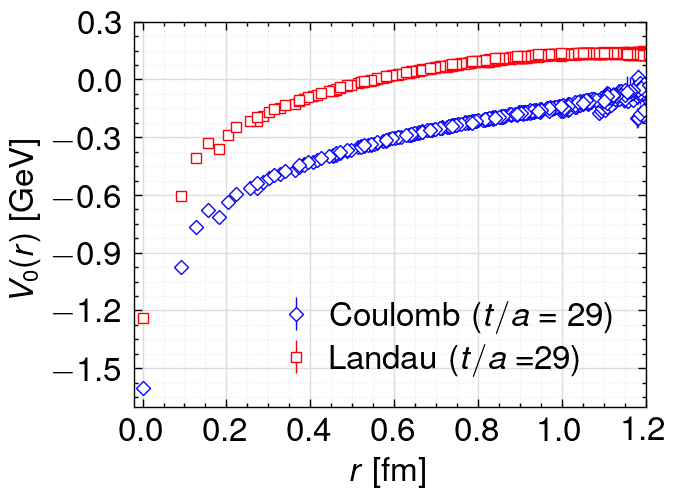

In [71]:
ct = 29
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")

fig, ax = plt.subplots()

errbar_plot_style = {
    "markersize": 3.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    fmt="D",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1],
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    fmt="s",
    color="xkcd:bright red",
    **errbar_plot_style,
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(-0.02, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$V_0(r)$ [GeV]", fontsize=12)
ax.set_ylim(-1.7, 0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/v0_CvsL.+29.eps", format="eps", dpi=600)
plt.close()

$V_0$ (shifted)

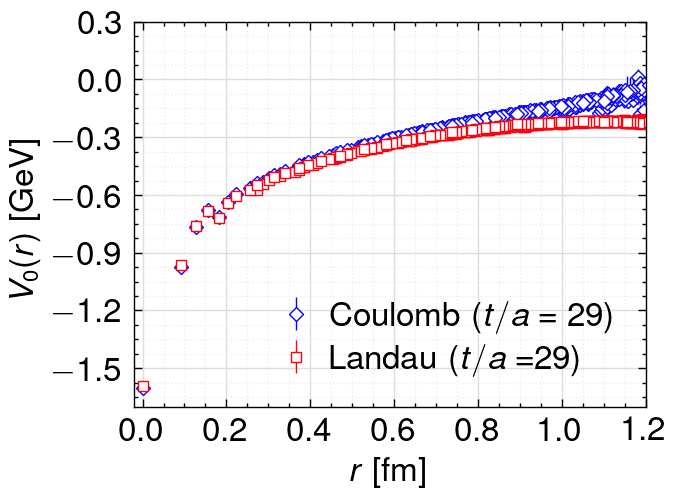

In [72]:
ct = 29
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")

fig, ax = plt.subplots()

errbar_plot_style = {
    "markersize": 3.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    fmt="D",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1] - 0.355,
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    fmt="s",
    color="xkcd:bright red",
    **errbar_plot_style,
)

ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(-0.02, 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$V_0(r)$ [GeV]", fontsize=12)
ax.set_ylim(-1.7, 0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/v0_CvsL.+29(shift).eps", format="eps", dpi=600)
plt.close()

$V_s$

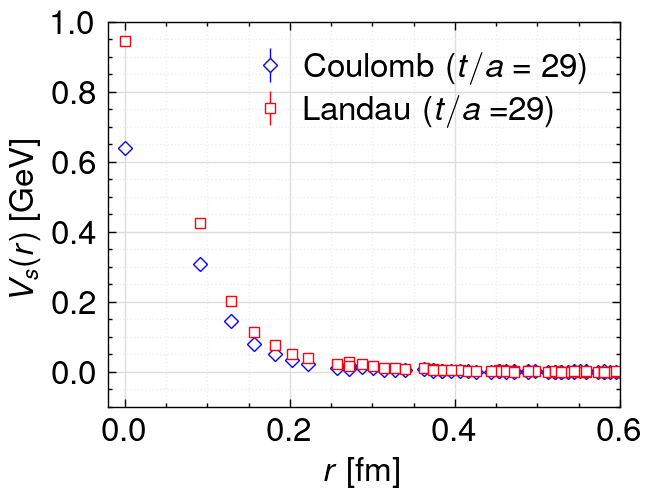

In [73]:
ct = 29
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")

fig, ax = plt.subplots()

errbar_plot_style = {
    "markersize": 3.5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 1,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 12,
}

ax.errorbar(
    vs_c[ct][:, 0] * a,
    vs_c[ct][:, 1],
    vs_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    fmt="D",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    vs_l[lt][:, 0] * a,
    vs_l[lt][:, 1],
    vs_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    fmt="s",
    color="xkcd:bright red",
    **errbar_plot_style,
)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$", fontsize=12)
ax.set_xlim(-0.02, 0.6)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.set_ylabel(r"$V_s(r)$ [GeV]", fontsize=12)
ax.set_ylim(-0.1, 1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax.tick_params(labelsize=12)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/vs_CvsL.+29.eps", format="eps", dpi=600)
plt.close()